## Capstone Final: Content-Based Boardgame Recommendation Systems

In this notebook, we'll be exploring Board Game data pulled from [boardgamegeek.com](https://www.boardgamegeek.com+) and using it to build content-based recommendation systems.

[Dataset](https://drive.google.com/file/d/1VOpTYteSZ3aLLdfS-7KUklx0GZEA_dTK/view?usp=sharing)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from wordcloud import WordCloud

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
filepath = Path('/content/gdrive/MyDrive/Thinkful - DS Flex/Capstone 4 - Final/BGG Data/games_detailed_final.csv')
df = pd.read_csv(filepath)
df.head()

,Unnamed: 0,Game_Name,Game_ID,Rank,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Description,Categories,Mechanics,Families,Minplayers,Maxplayers,Playingtime,Minplaytime,Maxplaytime,Long_Description
0,0,Gloomhaven,174430,1,2017.0,8.478,8.71,51157,Vanquish monsters with strategic cardplay. Ful...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Action Queue', 'Action Retrieval', 'Campaign...","['Category: Dungeon Crawler', 'Components: Min...",1.0,4.0,120.0,60.0,120.0,Gloomhaven is a game of Euro-inspired tactica...
1,1,Pandemic Legacy: Season 1,161936,2,2015.0,8.429,8.58,47064,Mutating diseases are spreading around the wor...,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...",2.0,4.0,60.0,60.0,60.0,Pandemic Legacy is a co-operative campaign gam...
2,2,Brass: Birmingham,224517,3,2018.0,8.426,8.66,29428,"Build networks, grow industries, and navigate ...","['Economic', 'Industry / Manufacturing', 'Post...","['Hand Management', 'Income', 'Loans', 'Market...","['Cities: Birmingham (England)', 'Country: Eng...",2.0,4.0,120.0,60.0,120.0,Brass: Birmingham is an economic strategy game...
3,3,Gloomhaven: Jaws of the Lion,291457,4,2020.0,8.262,8.61,20995,Vanquish monsters with strategic cardplay in a...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Action Queue', 'Action Retrieval', 'Campaign...","['Category: Dungeon Crawler', 'Components: Boo...",1.0,4.0,120.0,30.0,120.0,Gloomhaven: Jaws of the Lion is a standalone g...
4,4,Terraforming Mars,167791,5,2016.0,8.259,8.40,80030,Compete with rival CEOs to make Mars habitable...,"['Economic', 'Environmental', 'Industry / Manu...","['Closed Drafting', 'Contracts', 'Enclosure', ...","['Components: Map (Global Scale)', 'Components...",1.0,5.0,120.0,120.0,120.0,"In the 2400s, mankind begins to terraform the ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   Game_Name         10000 non-null  object 
 2   Game_ID           10000 non-null  int64  
 3   Rank              10000 non-null  int64  
 4   Year_Released     9978 non-null   float64
 5   Geek_Rating       10000 non-null  float64
 6   Average_Rating    10000 non-null  float64
 7   Number_of_Voters  10000 non-null  int64  
 8   Description       6295 non-null   object 
 9   Categories        10000 non-null  object 
 10  Mechanics         10000 non-null  object 
 11  Families          10000 non-null  object 
 12  Minplayers        10000 non-null  float64
 13  Maxplayers        10000 non-null  float64
 14  Playingtime       10000 non-null  float64
 15  Minplaytime       10000 non-null  float64
 16  Maxplaytime       10000 non-null  float64

We have null values for some Year_Released and lots of Descriptions. We don't anticipate making extensive use of the descriptions in our recommendation system but we should fill in the missing Year_Released.

In [ ]:
# drop extraneousl column
df.drop(columns=['Unnamed: 0'], inplace=True)

# year as int
df['Year_Released'].fillna(-1, inplace=True)
df['Year_Released'].astype(int)

0       2017
1       2015
2       2018
3       2020
4       2016
        ... 
9995    2018
9996    1993
9997    2018
9998    2021
9999    1980
Name: Year_Released, Length: 10000, dtype: int64

# Data Analysis

In this section we will inspect the distributions of the numerical variables.

For the categorical variables, categories, mechanics and families, we look to identify the most common values for each of them and discare the least common.

## Numerical Columns

In [ ]:
numerical_columns = ['Year_Released', 'Geek_Rating', 'Average_Rating', 'Number_of_Voters', 
                     'Minplayers', 'Maxplayers','Playingtime']

df[numerical_columns].describe()

,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Minplayers,Maxplayers,Playingtime
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2002.372700,5.902914,6.980131,1856.126400,1.924800,5.417300,118.397800
std,140.345547,0.449660,0.614739,5537.062302,0.698279,16.386965,466.995758
min,-3500.000000,5.557000,5.670000,30.000000,0.000000,0.000000,0.000000
25%,2007.000000,5.602000,6.520000,189.750000,2.000000,4.000000,30.000000
50%,2014.000000,5.710000,6.920000,435.000000,2.000000,4.000000,60.000000
75%,2018.000000,6.022000,7.380000,1251.000000,2.000000,6.000000,100.000000
max,2023.000000,8.478000,9.530000,112926.000000,9.000000,999.000000,22500.000000


In [ ]:
plt.style.use('dark_background')

DescribeResult(nobs=10000, minmax=(5.67, 9.53), mean=6.980131, variance=0.3779040632453245, skewness=0.4865688695105081, kurtosis=-0.10764070560674321)

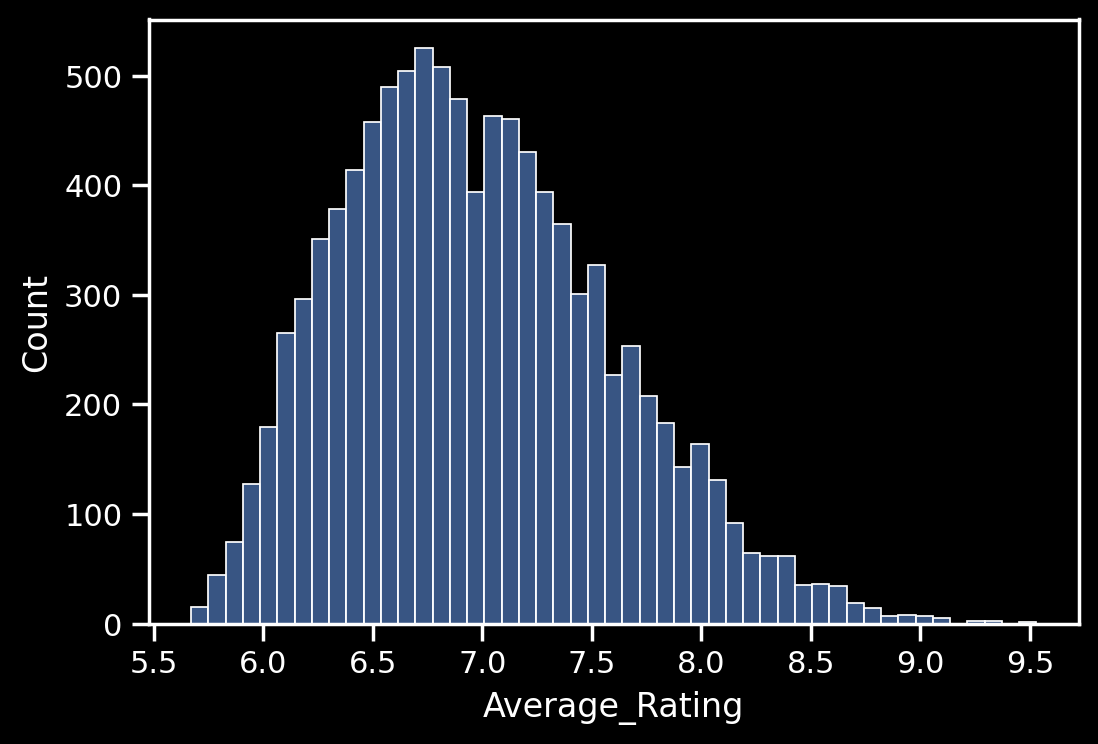

In [ ]:
ax = sns.histplot(df['Average_Rating'])
stats.describe(df['Average_Rating'])

Average Ratings are pleasantly normally distributed.

DescribeResult(nobs=10000, minmax=(5.557, 8.478), mean=5.9029137, variance=0.20219387884019402, skewness=1.9826547247620565, kurtosis=3.998954188580563)

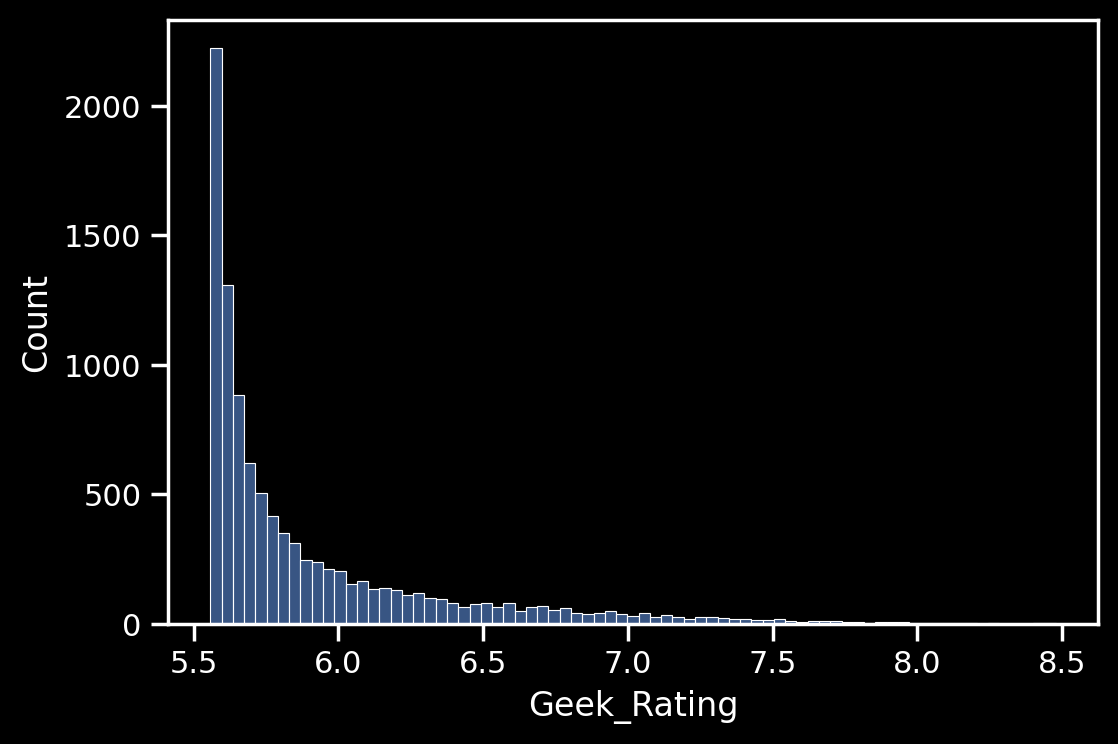

In [ ]:
ax = sns.histplot(df['Geek_Rating'])
stats.describe(df['Geek_Rating'])

The Geek Rating of a game is a baysean average. The specifics aren't entirely know, but we do know that lots of dummy 5.5 votes are included. This prevents new games with low number of votes from rocketing up the ratings charts.  [Source](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc4)

We see the effect here. Geek Averages are pulled dramatically back and it seems very difficult for the geek rating of any game to get past 6.

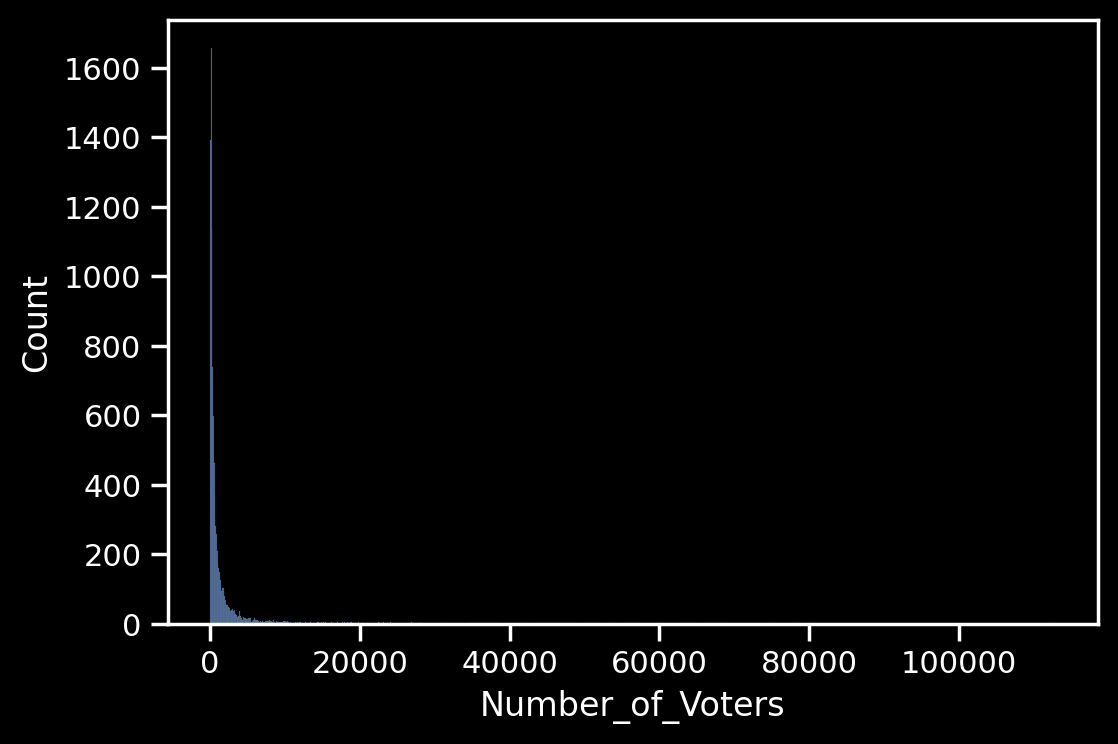

In [ ]:
ax = sns.histplot(df['Number_of_Voters'])

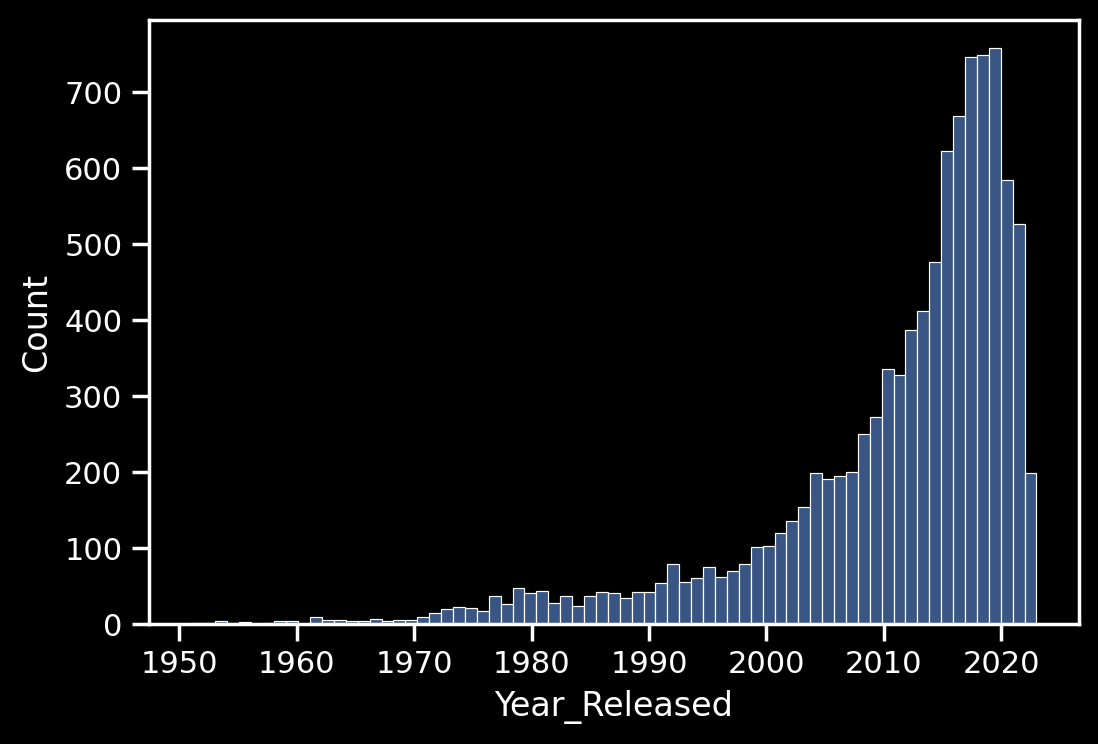

In [ ]:
# There are a few outlier year releases. We will exclude them from our histogram.
year_released = df[df['Year_Released'] > 1950]['Year_Released']

ax = sns.histplot(year_released)

If there's a graph to illustrate the explosion in modern boardgaming, it's this one. The overwhelming majority of games in our dataset were released after the year 2000.

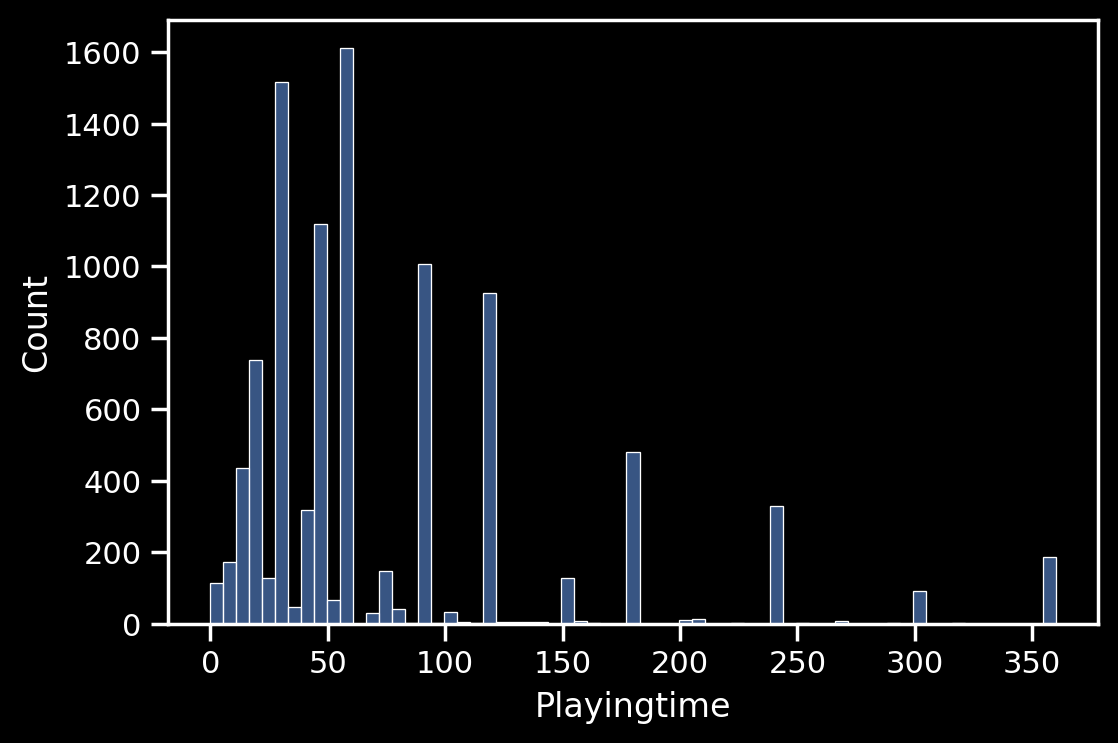

In [ ]:
# some outlier games have obnoxiously long playtimes listed
playingtime = df[df['Playingtime'] < 400]['Playingtime']
ax = sns.histplot(playingtime)

## Categorical Variables

Let's break down the three categorical variables and inspect which values are most common.

In [ ]:
cat_cols = ['Categories', 'Mechanics', 'Families']

# go through each value in the column, split on the columns and keep track of frequencies
def get_frequencies(column):
  values = {}

  for value in column:
      for word in value[1:-1].split(','):
          g = word.strip()[1:-1]

          if g == '':
            continue

          if g not in values.keys():
              values[g] = 0

          values[g] = values[g] + 1

  #sort dictionary by frequencies
  #values = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
  freq_df = pd.DataFrame.from_dict(values, orient='index')
  freq_df.rename(columns={0: 'Frequency'}, inplace=True)
  freq_df['Relative_Freq'] = freq_df['Frequency'] / freq_df['Frequency'].sum()
  freq_df.sort_values('Frequency', ascending=False, inplace=True)
  return freq_df

# find and record the frequencies of each value for the three cagegorical columns
cat_freq = {}

for column in cat_cols:

  cat_freq[column] = get_frequencies(df[column])
  print('Unique {} found: {}'.format(column, len(cat_freq[column])))


Unique Categories found: 84
Unique Mechanics found: 187
Unique Families found: 2837


There are a whole lot of possible values for each of our categorical varibales. It will help our train tim to cut out the rarest values.

In [ ]:
def cat_info(freq_dict, title):

  plt.barh(freq_dict.index.tolist(), freq_dict['Frequency'])
  plt.title('{} Frequencies'.format(title))
  plt.show()

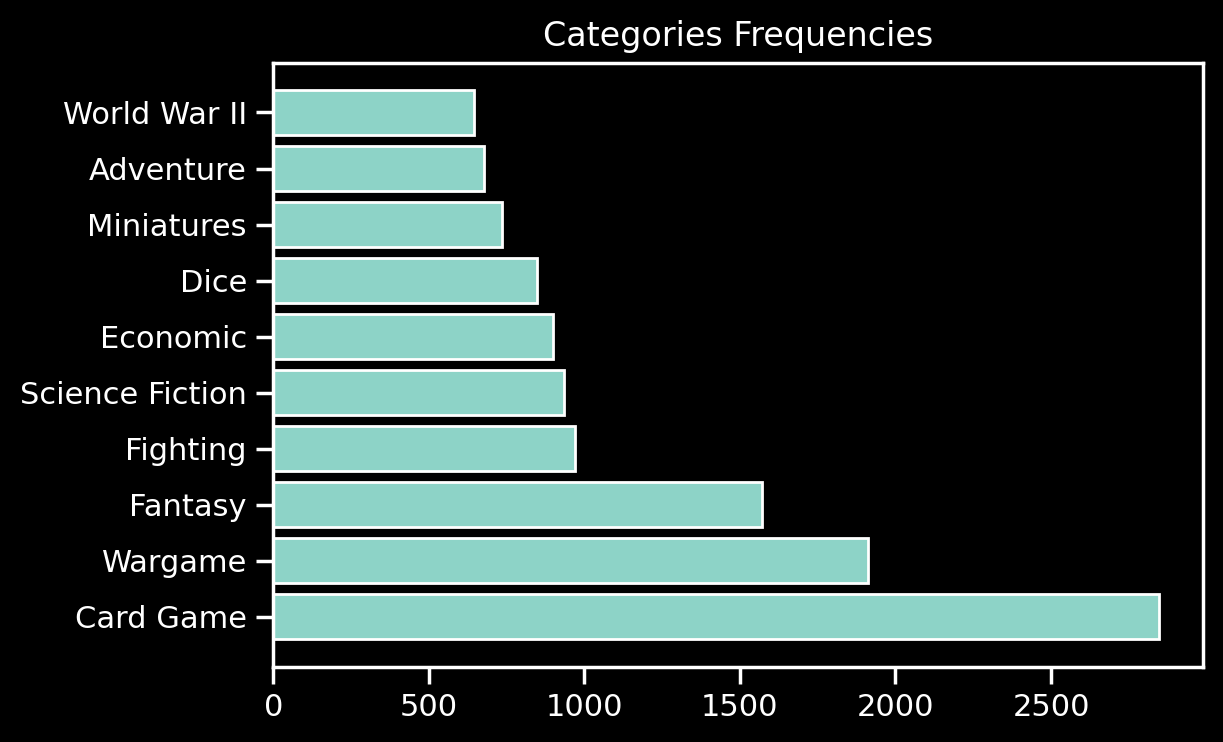

,Frequency,Relative_Freq
Card Game,2847,0.103727
Wargame,1912,0.069662
Fantasy,1571,0.057238
Fighting,970,0.035341
Science Fiction,935,0.034066
Economic,899,0.032754
Dice,847,0.030859
Miniatures,735,0.026779
Adventure,676,0.024629
World War II,644,0.023463


In [ ]:
cat_info(cat_freq['Categories'][:10], 'Categories')
cat_freq['Categories'].head(20)

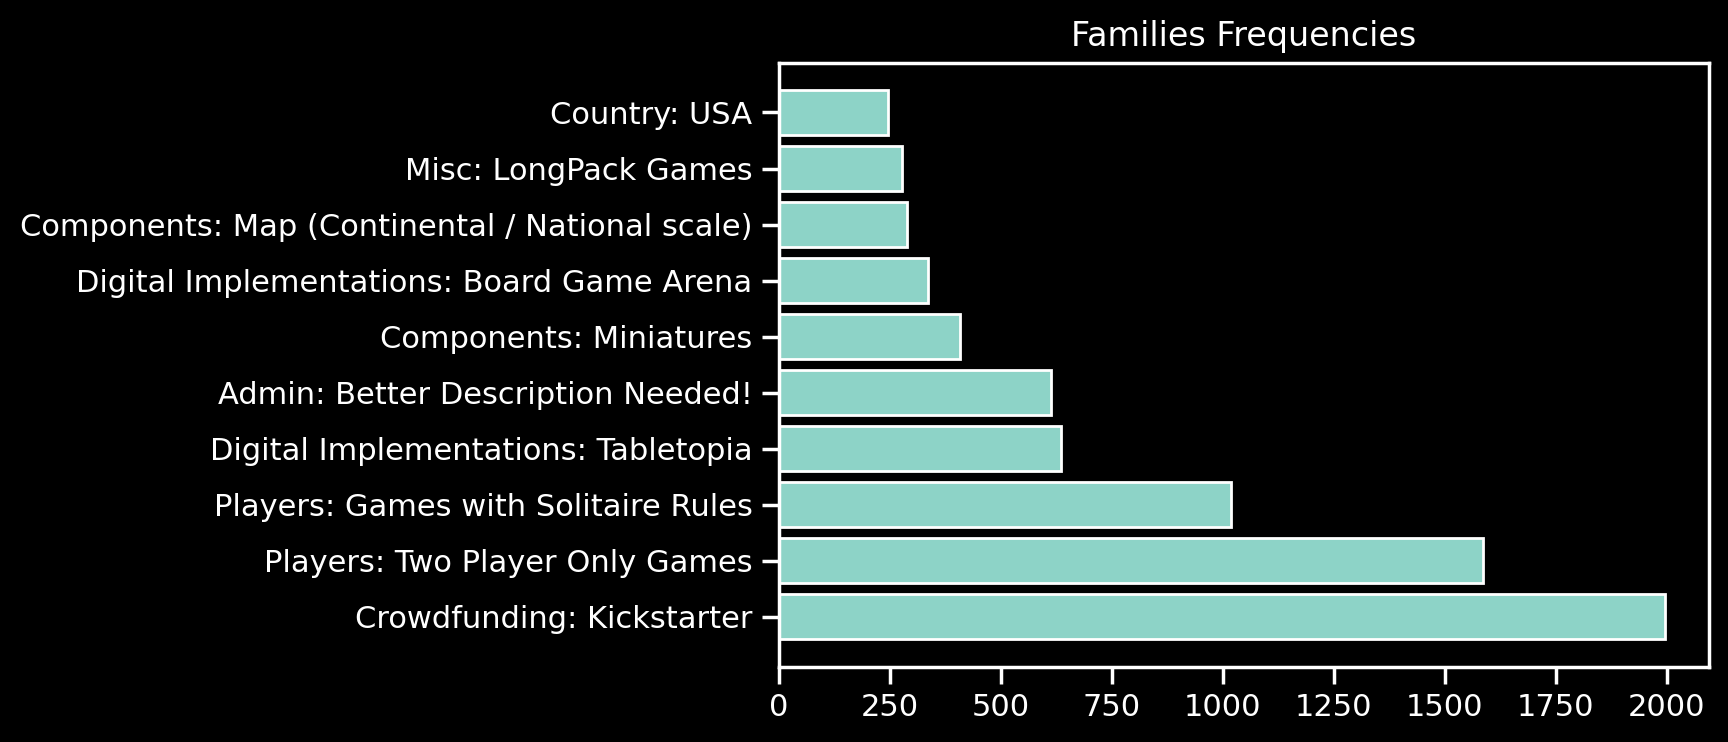

,Frequency,Relative_Freq
Crowdfunding: Kickstarter,1995,0.065922
Players: Two Player Only Games,1586,0.052407
Players: Games with Solitaire Rules,1018,0.033638
Digital Implementations: Tabletopia,635,0.020983
Admin: Better Description Needed!,613,0.020256
Components: Miniatures,408,0.013482
Digital Implementations: Board Game Arena,336,0.011103
Components: Map (Continental / National scale),289,0.009550
Misc: LongPack Games,277,0.009153
Country: USA,245,0.008096


In [ ]:
#there are a ton of families
fam_list = cat_freq['Families'][cat_freq['Families'] > 100]

cat_info(fam_list[:10], 'Families')
cat_freq['Families'].head(10)

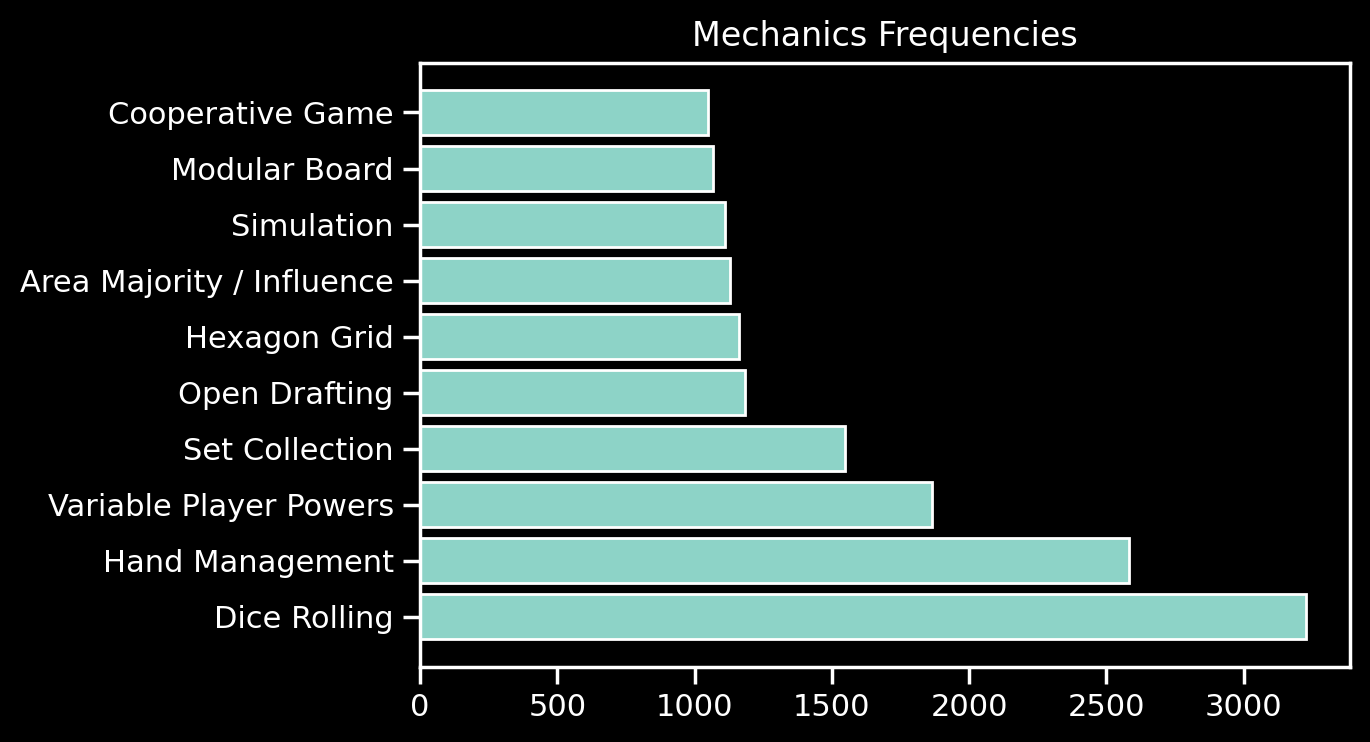

,Frequency,Relative_Freq
Dice Rolling,3227,0.083586
Hand Management,2584,0.066931
Variable Player Powers,1864,0.048281
Set Collection,1547,0.040070
Open Drafting,1185,0.030694
Hexagon Grid,1162,0.030098
Area Majority / Influence,1130,0.029269
Simulation,1111,0.028777
Modular Board,1067,0.027637
Cooperative Game,1047,0.027119


In [ ]:
cat_info(cat_freq['Mechanics'][:10], 'Mechanics')
cat_freq['Mechanics'].head(20)

# Create Categorical Columns

For Our recommendation system will find the distance between games, we need to transform our categorical variables to numerical. First, well throw out any family, mechanic or category that appears in less than 1% of our games.

Then a column will be added for each value left. 1 will represent its presence and 0 its absense for the game.

In [ ]:
# number to cutoff at
cutoff = 0.001 * 100000

# weights for categories, mechanics and families
cat_weights = {'Categories': 3, 'Mechanics': 2, 'Families': 1}

# Record all the columns we add to the dataframe
columns_added = []

for category in cat_cols:
  cat_df = cat_freq[category]

  # cut off the rarest values
  cat_df = cat_df[cat_df['Frequency'] >= cutoff]

  print('{} values left for {}.'.format(len(cat_df.index), category))

  # create a new column for values left and make it equal to the weight of the category if
  # present for the current game
  for value in cat_df.index:
    df[value] = 0
    df[value] = [cat_weights[category] if value in x else 0 for x in df[category]]
    columns_added.append(value)


63 values left for Categories.
61 values left for Mechanics.
36 values left for Families.


# Nearest Neighbors Recommendation System

For our model, we will use our data to find the euclidean distances between games.

In [ ]:
#make a category dataframe with bgg_id as the index for knn calculations

categories = df[columns_added + ['Game_ID']].copy()

# make sure the game id is indexed so it's not used for calculating distances
categories.set_index('Game_ID', inplace=True)

In [ ]:
categories

,Card Game,Wargame,Fantasy,Fighting,Science Fiction,Economic,Dice,Miniatures,Adventure,World War II,...,Mechanism: Roll-and-Write,Players: Two Players Only Wargames,Country: Russia,Creatures: Dragons,Theme: Food / Cooking,Country: Italy,Components: Sand Timers,Players: Solitaire Only Wargames,Misc: Mensa Select,Continents: Europe
Game_ID,,,,,,,,,,,,,,,,,,,,,
174430,0,0,3,3,0,0,0,3,3,0,...,0,0,0,1,0,0,0,0,0,0
161936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224517,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
291457,0,0,3,3,0,0,0,3,3,0,...,0,0,0,0,0,0,0,0,0,0
167791,0,0,0,0,3,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
256381,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Instantiate our model with the categorical data and set it to find the nearest 10 neighbors
knn = NearestNeighbors(metric='minkowski', algorithm='brute', n_neighbors=11, n_jobs=-1)
knn.fit(categories)

NearestNeighbors(algorithm='brute', n_jobs=-1, n_neighbors=11)

In [ ]:
# function that takes a game, finds a list of its nearest neighbors and gets those games' information from the main df

def get_neighborhood(knn, game, features):
    distances, near_games = knn.kneighbors([features.loc[game]])

    neighbor_games = pd.DataFrame()
    neighbor_games['Game_ID'] = categories.index[near_games[0]]
    neighbor_games['distance'] = distances[0]
    
    return neighbor_games.merge(df, on='Game_ID').copy()

In [ ]:
# helper function to display the game and a link to its BGG page
def display_recommendations(df_recs):
  for index, game in df_recs.iterrows():
    if index == 0:
      print('Recomendations for {}({}) - {}'.format(game['Game_Name'], int(game['Year_Released']), game['Geek_Rating']))
      print('https://boardgamegeek.com/boardgame/{}'.format(game['Game_ID']))
      print('')
    else:
      print('{}. {}({}) - {}: https://boardgamegeek.com/boardgame/{}'.format(index, game['Game_Name'], int(game['Year_Released']),game['Geek_Rating'], game['Game_ID']))
      print('\t{}\n'.format(game['Description'])) 
      #print('{}. {}({}) - {}: {}'.format(index, game['Game_Name'], int(game['Game_ID']),game['Geek_Rating'], game['Description']))

We'll start testing our implementation by looking at the, currently, number one ranked game, Gloomhaven.

In [ ]:
df_recs = get_neighborhood(knn, 174430, categories)
display_recommendations(df_recs)

Recomendations for Gloomhaven(2017) - 8.478
https://boardgamegeek.com/boardgame/174430

1. Frosthaven(2022) - 5.716: https://boardgamegeek.com/boardgame/295770
	Adventure in the frozen north and build up your outpost throughout an epic campaign.

2. Gloomhaven: Jaws of the Lion(2020) - 8.262: https://boardgamegeek.com/boardgame/291457
	Vanquish monsters with strategic cardplay in a 25-scenario Gloomhaven campaign.

3. Bardsung(2022) - 5.802: https://boardgamegeek.com/boardgame/322524
	Inspire the Songs. Live your Legend.

4. Middara: Unintentional Malum – Act 1(2019) - 6.972: https://boardgamegeek.com/boardgame/169427
	Coop dungeon crawler in unusual fantasy setting with massive campaign and storyline.

5. Mage Knight Board Game(2011) - 7.87: https://boardgamegeek.com/boardgame/96848
	Build your hero’s spells, abilities, and artifacts as you explore & conquer cities.

6. Etherfields(2020) - 6.663: https://boardgamegeek.com/boardgame/280794
	Discover a series of unique Dreams through te

This list looks very successful! The first couple of games are a reimplementation and the upcoming sequal. Beyond that we run into games with multiple similarities to the original. Most look to be fantasy themed, cooperative so-called dungeon crawlers.

Next let's inspect a classic: chess.

In [ ]:
df_recs = get_neighborhood(knn, 335869, categories)
display_recommendations(df_recs)

Recomendations for A Little Wordy(2021) - 5.787
https://boardgamegeek.com/boardgame/335869

1. Scarabeo(1963) - 5.635: https://boardgamegeek.com/boardgame/12747
	nan

2. Super Scrabble(2004) - 5.679: https://boardgamegeek.com/boardgame/11182
	nan

3. Jarnac(1977) - 5.612: https://boardgamegeek.com/boardgame/7451
	Make the longest words possible or extend existing ones until 8 lines are completed.

4. Upwords(1982) - 5.62: https://boardgamegeek.com/boardgame/1515
	A 3-dimensional word game. Spell out, stack up and score high!

5. What's My Word?(1972) - 5.771: https://boardgamegeek.com/boardgame/4079
	Deduce your opponent's secret word by guessing shorter words that partially match.

6. P for Pizza(2020) - 5.566: https://boardgamegeek.com/boardgame/311330
	Now's your chance to build your own giant slice of pizza!

7. Mixmo(2009) - 5.634: https://boardgamegeek.com/boardgame/42105
	nan

8. Bananagrams WildTiles(2014) - 5.576: https://boardgamegeek.com/boardgame/164917
	nan

9. Scattergori

In [ ]:
df_recs = get_neighborhood(knn, 171, categories)
display_recommendations(df_recs)

Recomendations for Chess(1475) - 6.974
https://boardgamegeek.com/boardgame/171

1. International Checkers(1600) - 5.614: https://boardgamegeek.com/boardgame/26952
	nan

2. SHŌBU(2019) - 6.356: https://boardgamegeek.com/boardgame/272380
	Use your stones to push all your opponent's stones off any one of four boards to win!

3. Shogi(1587) - 6.331: https://boardgamegeek.com/boardgame/2065
	Deploy captured pieces for rapid checkmates in Japan's traditional "general's game."

4. Chess960(1996) - 5.629: https://boardgamegeek.com/boardgame/12608
	Disrupt book knowledge with a different force structure every game.

5. Camelot(1930) - 5.637: https://boardgamegeek.com/boardgame/5251
	An abstract game of jumping and capture enlivened by medieval knights and men-at-arms

6. Quoridor(1997) - 6.38: https://boardgamegeek.com/boardgame/624
	Either move your pawn or place a wall to cross the board first.

7. Talat(2008) - 5.584: https://boardgamegeek.com/boardgame/39406
	nan

8. Laser Chess(2011) - 5.8

Here we get a nice list of abstract game.

In [ ]:
df_recs = get_neighborhood(knn, 13, categories)
display_recommendations(df_recs)

Recomendations for CATAN(1995) - 6.956
https://boardgamegeek.com/boardgame/13

1. Catan: Family Edition(2012) - 5.637: https://boardgamegeek.com/boardgame/147240
	nan

2. Catan Histories: Rise of the Inkas(2018) - 5.779: https://boardgamegeek.com/boardgame/244144
	Relive the rise and fall of Inkas, Catan style!

3. Offshore(2019) - 5.631: https://boardgamegeek.com/boardgame/283867
	nan

4. Vernissage(1993) - 5.582: https://boardgamegeek.com/boardgame/332
	A game of speculation and dirty tricks in the art world.

5. Istanbul(2014) - 7.412: https://boardgamegeek.com/boardgame/148949
	Send your assistants through the shops of Istanbul as you race to acquire rubies.

6. Catan: Ancient Egypt(2014) - 5.796: https://boardgamegeek.com/boardgame/161527
	Gather your resources and build settlements in the fertile Nile Valley!

7. Franchise(2018) - 5.83: https://boardgamegeek.com/boardgame/245645
	Spread your franchise across USA to control regions & establish monopolies in cities.

8. Winter King

In [ ]:
df_recs = get_neighborhood(knn, 320, categories)
display_recommendations(df_recs)

Recomendations for Scrabble(1948) - 6.154
https://boardgamegeek.com/boardgame/320

1. Upwords(1982) - 5.62: https://boardgamegeek.com/boardgame/1515
	A 3-dimensional word game. Spell out, stack up and score high!

2. Super Scrabble(2004) - 5.679: https://boardgamegeek.com/boardgame/11182
	nan

3. Scarabeo(1963) - 5.635: https://boardgamegeek.com/boardgame/12747
	nan

4. A Little Wordy(2021) - 5.787: https://boardgamegeek.com/boardgame/335869
	A sneaky tile-unscrambling game for aspiring geniuses and would-be word wizards.

5. SHH(2015) - 5.722: https://boardgamegeek.com/boardgame/164158
	Cooperate in silence to spell words and rid your hands of as many letters as possible

6. Jarnac(1977) - 5.612: https://boardgamegeek.com/boardgame/7451
	Make the longest words possible or extend existing ones until 8 lines are completed.

7. P for Pizza(2020) - 5.566: https://boardgamegeek.com/boardgame/311330
	Now's your chance to build your own giant slice of pizza!

8. What's My Word?(1972) - 5.771

# TF-IDF Description Similarity Recommender

We will make an alternative model looking at the kinds of words used in the longer descriptions of the games. The idea being that similar games will use similar words within their descriptions. Our assumption with this recommender will be that descriptions are written with the most relevant information in mind.

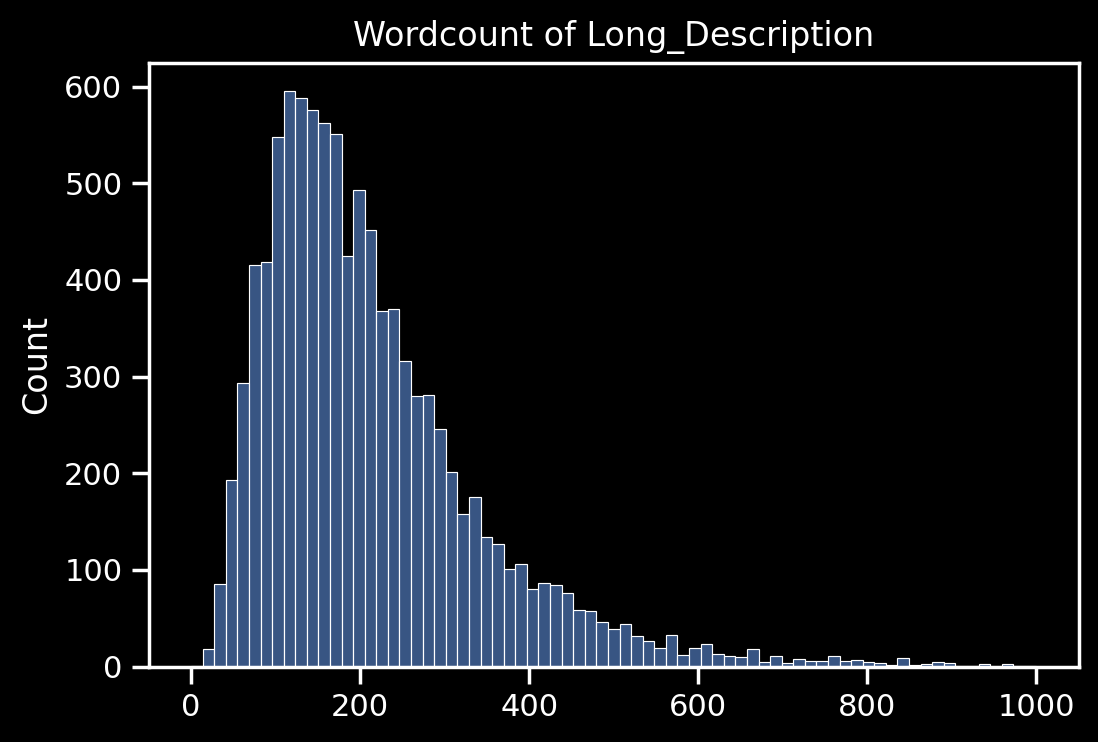

In [ ]:
desc_lengths = [len(x.split()) for x in df['Long_Description'].tolist()]
ax = sns.histplot(desc_lengths, binrange=[0,1000])
plt.title('Wordcount of Long_Description')
plt.show()

The vast majority of detailed descriptions have more than two hundered words. This should be enough for TF-IDF.

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(df['Long_Description'])

tfidf_matrix.shape

(10000, 49282)

Our vocabulary has ended up with over forty-nine thousand words. We'll next turn our matrix into a more readable dataframe.

In [ ]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), 
                        columns=tfidf.get_feature_names(),
                        index=df['Game_Name'])

df_tfidf

,00,000,000m,000men,001,002,007,00h,01,011,...,zwischendurch,zwnj,zwo,zwyci,zygmunta,zygons,zyska,zyskiwa,zz,zzzs
Game_Name,,,,,,,,,,,,,,,,,,,,,
Gloomhaven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pandemic Legacy: Season 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brass: Birmingham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gloomhaven: Jaws of the Lion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Terraforming Mars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fortune City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Roman Civil War,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fado: Duetos e Desgarradas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# helper function to make wordclouds of TFIDF data
# filter_zeroes to True if it throws a div by zero error
def make_wordcloud(word_list, filter_zeroes=False):

  if filter_zeroes:
    word_list = word_list[word_list > 0]

  wc = WordCloud(background_color='black',width=5000,height=5000,max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_list)
  
  plt.xticks([])
  plt.yticks([])
  plt.box(False)
  plt.imshow(wc)
  plt.show()

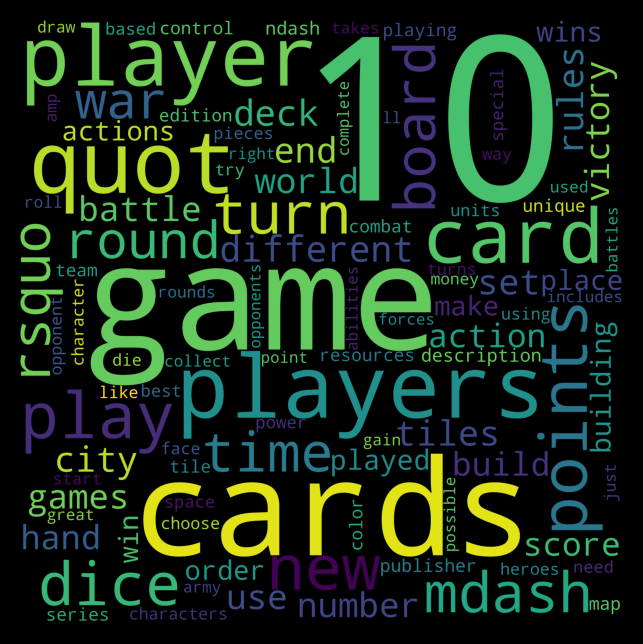

In [ ]:
make_wordcloud(df_tfidf.T.sum(axis=1))

We'll use the cosine similarity between vectors. Because our scores come from the TF_IDF vecotrizer, we just need to calculate the dot product.

In [ ]:
cos_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def get_recommendations_tf_idf(bgg_id):

  # find the index of our game from database id
  game_rank = int(df[df['Game_ID'] == bgg_id]['Rank'])

  # get a list of tuples of the (index of game, TF_IDF similarity with given game)
  similarity_scores = list(enumerate(cos_similarity[game_rank-1]))

  # sort the list by highest scores and take the top 10 (not including original game)
  similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
  similarity_scores = similarity_scores[0:11]

  recomendations = pd.DataFrame()
  recomendations['Rank'] = [x[0]+1 for x in similarity_scores]
  recomendations['Distance'] = [x[1] for x in similarity_scores]
  
  return recomendations.merge(df, on='Rank').copy()

In [ ]:
df_recs = get_recommendations_tf_idf(174430)
display_recommendations(df_recs)

Recomendations for Gloomhaven(2017) - 8.478
https://boardgamegeek.com/boardgame/174430

1. Combat!(2019) - 5.771: https://boardgamegeek.com/boardgame/253652
	A solitaire game of man to man combat in the 20th century.

2. Night of Man(2015) - 5.576: https://boardgamegeek.com/boardgame/169986
	nan

3. Destinies(2021) - 7.073: https://boardgamegeek.com/boardgame/285192
	Characters explore a medieval-fantasy land as they race to fulfill their destiny.

4. Avanti(2011) - 5.577: https://boardgamegeek.com/boardgame/91668
	nan

5. Dungeons & Dragons: Temple of Elemental Evil Board Game(2015) - 6.367: https://boardgamegeek.com/boardgame/172220
	Explore the monster-infested dungeons beneath the Sword Coast.

6. nana(2021) - 5.558: https://boardgamegeek.com/boardgame/352515
	Where you can you find another card with that number? My hand? Their hand? Which end?

7. No Retreat! Italian Front: 1943-45(2015) - 5.705: https://boardgamegeek.com/boardgame/150013
	Allied Invasion of Italy, using the popul

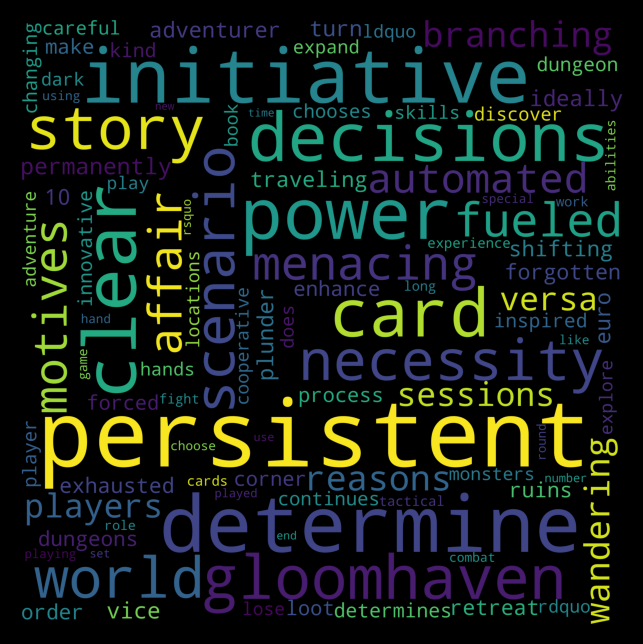

In [ ]:
make_wordcloud(df_tfidf.loc['Gloomhaven'], filter_zeroes=True)

In [ ]:
df_recs = get_recommendations_tf_idf(171)
display_recommendations(df_recs)

Recomendations for Chess(1475) - 6.974
https://boardgamegeek.com/boardgame/171

1. No Stress Chess(2004) - 5.576: https://boardgamegeek.com/boardgame/19918
	Play the world's greatest game, simplified for youngsters!

2. Martian Chess(1995) - 5.649: https://boardgamegeek.com/boardgame/19803
	Capture your opponent's pieces before they cross the Canal and become yours.

3. Six Making(2013) - 5.715: https://boardgamegeek.com/boardgame/149910
	nan

4. Bughouse Chess(1960) - 5.795: https://boardgamegeek.com/boardgame/14188
	nan

5. Shuuro(2008) - 5.588: https://boardgamegeek.com/boardgame/38764
	Discard the traditional chess set and build a custom army to conquer the board.

6. 4 Player Chess(1881) - 5.566: https://boardgamegeek.com/boardgame/2173
	Chess with 4 players instead of 2. It can be partners or everyone for themselves.

7. Proteus(2001) - 5.613: https://boardgamegeek.com/boardgame/2211
	Make chess moves and attacks with dice...then change their personae.

8. Paco Ŝako(2017) - 5.655

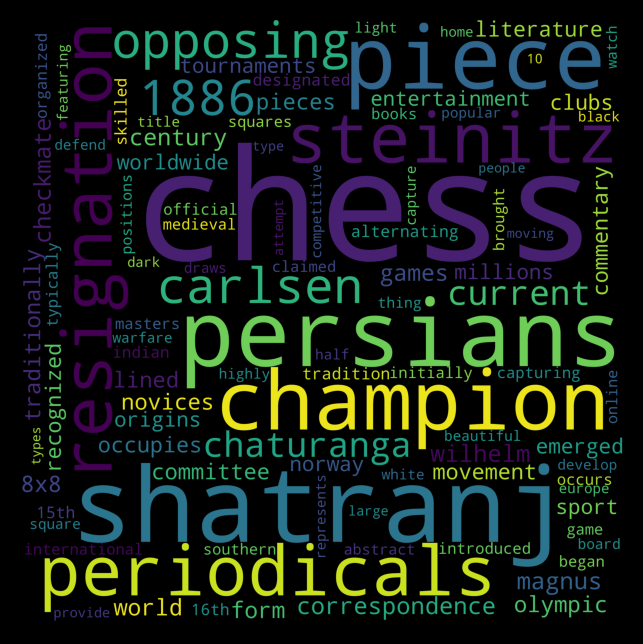

In [ ]:
make_wordcloud(df_tfidf.loc['Chess'], filter_zeroes=True)

Chess being such a unique word, we get a bunch of chess variants and other games that mention chess-like play.

In [ ]:
df_recs = get_recommendations_tf_idf(13)
display_recommendations(df_recs)

Recomendations for CATAN(1995) - 6.956
https://boardgamegeek.com/boardgame/13

1. The Settlers of Zarahemla(2003) - 5.795: https://boardgamegeek.com/boardgame/6778
	nan

2. Simply Catan(2006) - 5.615: https://boardgamegeek.com/boardgame/24511
	nan

3. Struggle for Catan(2011) - 5.85: https://boardgamegeek.com/boardgame/91534
	Gather, trade and then spend resources to grow your own Catanian empire.

4. Settlers of Catan: Gallery Edition(2008) - 5.728: https://boardgamegeek.com/boardgame/38821
	nan

5. Rivals for Catan(2010) - 6.595: https://boardgamegeek.com/boardgame/66056
	Duel to build the best kingdom in different eras of Catan.

6. Catan: Family Edition(2012) - 5.637: https://boardgamegeek.com/boardgame/147240
	nan

7. Elasund: The First City(2005) - 6.209: https://boardgamegeek.com/boardgame/19526
	Build & fortify city together. Make sure that pirates will plunder others, not you.

8. Catan: Traveler – Compact Edition(2015) - 5.737: https://boardgamegeek.com/boardgame/172994
	Coll

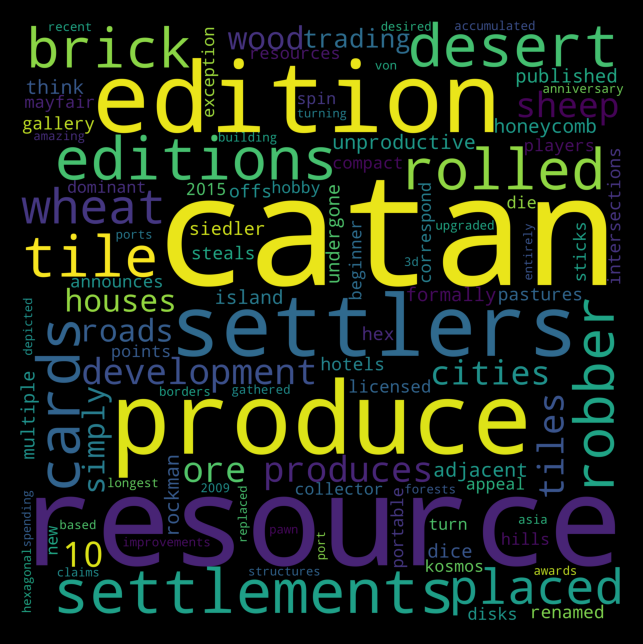

In [ ]:
make_wordcloud(df_tfidf.loc['CATAN'])

In [ ]:
df_recs = get_recommendations_tf_idf(320)
display_recommendations(df_recs)

Recomendations for Scrabble(1948) - 6.154
https://boardgamegeek.com/boardgame/320

1. Scarabeo(1963) - 5.635: https://boardgamegeek.com/boardgame/12747
	nan

2. Upwords(1982) - 5.62: https://boardgamegeek.com/boardgame/1515
	A 3-dimensional word game. Spell out, stack up and score high!

3. Das perfekte Wort(2021) - 5.59: https://boardgamegeek.com/boardgame/326112
	Find the perfect word for the perfect score.

4. Prolix(2010) - 5.626: https://boardgamegeek.com/boardgame/39635
	nan

5. Kiitos(2020) - 5.562: https://boardgamegeek.com/boardgame/300509
	Form words with letters that may or may not be in your opponents' hands.

6. Jarnac(1977) - 5.612: https://boardgamegeek.com/boardgame/7451
	Make the longest words possible or extend existing ones until 8 lines are completed.

7. A Little Wordy(2021) - 5.787: https://boardgamegeek.com/boardgame/335869
	A sneaky tile-unscrambling game for aspiring geniuses and would-be word wizards.

8. Letter Jam(2019) - 6.673: https://boardgamegeek.com/boa

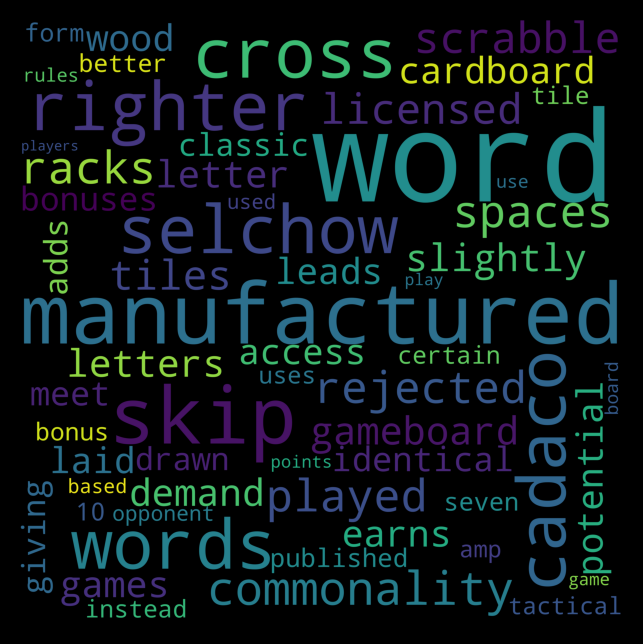

In [ ]:
make_wordcloud(df_tfidf.loc['Scrabble'], filter_zeroes=True)

# Conclusions

We've successfully made two recommendation systems. 

The first used categorical information about the games in the database and calculated the closely related neighbors based on euclidean distances. It was highly successful in finding related games that shared a lot of these human-generated tags. If a game did not have many of these, the system struggled to find appropriate recommendations.

The second system used a TF-IDF measurement using the long descriptions of each game. Games that shared unusual terms between their descriptions ended up being more closely related. This approach helped with games that did not have many of the human-generated tags. It wasn't alwyas good at finding mechanically related games.

On the whole, I think the first system performed better. BGG's database has been continually maintained for over twenty years. The categorical tags associated with each game are a good heuristic in finding similar games. The second recommendation system would fit well has a backup in the case that there are not enough detailed categories for the first system to give appropriate recommendations.

# Bonus

Below is a recommendation system that finds the "average" categories for a given list of games and generates recommendations based on the grouping.

It's not very good.

In [ ]:

def get_neighborhood_group(knn, games, features):
    avg_game = categories.loc[games].mean()
    distances, near_games = knn.kneighbors([avg_game])

    neighbor_games = pd.DataFrame()
    neighbor_games['Game_ID'] = categories.index[near_games[0]]
    neighbor_games['distance'] = distances[0]
    
    return neighbor_games.merge(df, on='Game_ID').copy()

df_recs = get_neighborhood_group(knn, [174430, 291457], categories)
df_recs

,Game_ID,distance,Game_Name,Rank,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Description,Categories,...,Mechanism: Roll-and-Write,Players: Two Players Only Wargames,Country: Russia,Creatures: Dragons,Theme: Food / Cooking,Country: Italy,Components: Sand Timers,Players: Solitaire Only Wargames,Misc: Mensa Select,Continents: Europe
0,291457,2.345208,Gloomhaven: Jaws of the Lion,4,2020.0,8.262,8.61,20995,Vanquish monsters with strategic cardplay in a...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
1,174430,2.345208,Gloomhaven,1,2017.0,8.478,8.71,51157,Vanquish monsters with strategic cardplay. Ful...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,1,0,0,0,0,0,0
2,295770,3.082207,Frosthaven,4926,2022.0,5.716,6.89,620,Adventure in the frozen north and build up you...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
3,322524,5.787918,Bardsung,3942,2022.0,5.802,7.94,489,Inspire the Songs. Live your Legend.,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
4,169427,6.204837,Middara: Unintentional Malum – Act 1,439,2019.0,6.972,8.75,1970,Coop dungeon crawler in unusual fantasy settin...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
5,66356,6.595453,Dungeons & Dragons: Wrath of Ashardalon Board ...,841,2011.0,6.655,7.11,6236,A terrifying red dragon lurks deep within a mo...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,1,0,0,0,0,0,0
6,96848,6.670832,Mage Knight Board Game,33,2011.0,7.870,8.09,30309,"Build your hero’s spells, abilities, and artif...","['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
7,295785,6.745369,Euthia: Torment of Resurrection,1695,2021.0,6.245,8.76,817,An epic competitive board game inspired by RPG...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
8,192315,6.819091,Widower's Wood: An Iron Kingdoms Adventure Boa...,8776,2017.0,5.576,7.08,104,NaN,"['Adventure', 'Exploration', 'Fantasy', 'Fight...",...,0,0,0,0,0,0,0,0,0,0
9,269385,6.964194,The Lord of the Rings: Journeys in Middle-Earth,97,2019.0,7.536,7.97,12613,"Heroes explore Middle-earth, working together ...","['Adventure', 'Fantasy', 'Fighting', 'Miniatur...",...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Scrabble + Chess
df_recs = get_neighborhood_group(knn, [171, 320], categories)
df_recs

,Game_ID,distance,Game_Name,Rank,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Description,Categories,...,Mechanism: Roll-and-Write,Players: Two Players Only Wargames,Country: Russia,Creatures: Dragons,Theme: Food / Cooking,Country: Italy,Components: Sand Timers,Players: Solitaire Only Wargames,Misc: Mensa Select,Continents: Europe
0,272380,3.162278,SHŌBU,1394,2019.0,6.356,7.57,1300,Use your stones to push all your opponent's st...,['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
1,91034,3.162278,Laser Chess,3572,2011.0,5.845,6.68,799,Move mirrored pieces to reflect lasers at your...,"['Abstract Strategy', 'Electronic']",...,0,0,0,0,0,0,0,0,0,0
2,160477,3.162278,Onitama,270,2014.0,7.177,7.38,18543,Assert your martial prowess by harnessing the ...,['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
3,5251,3.162278,Camelot,6402,1930.0,5.637,6.73,283,An abstract game of jumping and capture enlive...,['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
4,171,3.162278,Chess,433,1475.0,6.974,7.16,32117,"Orchestrate your powerful royalty, clergy and ...",['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
5,39406,3.162278,Talat,8347,2008.0,5.584,6.28,222,NaN,['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
6,12608,3.162278,Chess960,6612,1996.0,5.629,7.60,134,Disrupt book knowledge with a different force ...,['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
7,320,3.162278,Scrabble,1991,1948.0,6.154,6.27,29202,Carefully place your lettered tiles to make hi...,['Word Game'],...,0,0,0,0,0,0,0,0,0,0
8,26952,3.162278,International Checkers,7078,1600.0,5.614,6.51,277,NaN,['Abstract Strategy'],...,0,0,0,0,0,0,0,0,0,0
9,624,3.316625,Quoridor,1334,1997.0,6.380,6.66,7154,Either move your pawn or place a wall to cross...,"['Abstract Strategy', 'Maze']",...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# CATAN + Bridge
df_recs = get_neighborhood_group(knn, [13, 2181], categories)
df_recs

,Game_ID,distance,Game_Name,Rank,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Description,Categories,...,Mechanism: Roll-and-Write,Players: Two Players Only Wargames,Country: Russia,Creatures: Dragons,Theme: Food / Cooking,Country: Italy,Components: Sand Timers,Players: Solitaire Only Wargames,Misc: Mensa Select,Continents: Europe
0,4583,4.387482,Pinochle,2726,1864.0,5.979,6.88,1000,"Meld families, and throw some aces around in t...",['Card Game'],...,0,0,0,0,0,0,0,0,0,0
1,147240,4.387482,Catan: Family Edition,6408,2012.0,5.637,6.58,386,NaN,['Negotiation'],...,0,0,0,0,0,0,0,0,0,0
2,173092,4.387482,Träxx,4018,2015.0,5.793,6.58,647,"Draw a route across a colorful grid, across as...",[],...,0,0,0,0,0,0,0,0,0,0
3,2181,4.387482,Bridge,818,1925.0,6.669,7.45,2984,Bid to communicate and to set trump. Then take...,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
4,79067,4.387482,Hex Hex XL,5090,2010.0,5.704,6.73,367,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
5,1324,4.387482,Café International: Das Kartenspiel,9238,2001.0,5.568,5.73,899,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
6,111172,4.387482,Crooks,8415,2012.0,5.583,6.12,328,"Gather teams of crooks, assign them to jobs an...","['Card Game', 'Mafia']",...,0,0,0,0,0,0,0,0,0,0
7,232345,4.387482,Cahoots,6766,2018.0,5.624,6.45,261,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
8,145478,4.387482,HeartSwitch,7553,2013.0,5.601,6.49,222,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
9,1271,4.387482,Volltreffer,9178,1999.0,5.569,6.72,104,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df[['catan' in x.lower() for x in df['Game_Name']]]

,Game_Name,Game_ID,Rank,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Description,Categories,Mechanics,...,Mechanism: Roll-and-Write,Players: Two Players Only Wargames,Country: Russia,Creatures: Dragons,Theme: Food / Cooking,Country: Italy,Components: Sand Timers,Players: Solitaire Only Wargames,Misc: Mensa Select,Continents: Europe
455,CATAN,13,456,1995.0,6.956,7.12,112417,Collect and trade resources to build up the is...,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...",...,0,0,0,0,0,0,0,0,0,0
928,Rivals for Catan,66056,929,2010.0,6.595,6.95,6659,Duel to build the best kingdom in different er...,"['Card Game', 'City Building', 'Medieval', 'Te...","['Dice Rolling', 'Hand Management', 'Open Draf...",...,0,0,0,0,0,0,0,0,0,0
1067,Catan Card Game,278,1068,1996.0,6.521,6.71,13510,"Build buildings with special abilities, hire h...","['Card Game', 'City Building', 'Territory Buil...","['Dice Rolling', 'Hand Management', 'Open Draf...",...,0,0,0,0,0,0,0,0,0,0
1226,Star Trek: Catan,117985,1227,2012.0,6.438,7.00,3476,"Explorers in the Final Frontier trade, settle,...","['Movies / TV / Radio theme', 'Negotiation', '...","['Dice Rolling', 'Hand Management', 'Modular B...",...,0,0,0,0,0,0,0,0,0,0
1234,Starship Catan,2338,1235,2001.0,6.433,6.84,4369,Upgrade your space ship as you explore the gal...,"['Card Game', 'Exploration', 'Science Fiction'...","['Dice Rolling', 'Memory', 'Push Your Luck', '...",...,0,0,0,0,0,0,0,0,0,0
1246,The Starfarers of Catan,1897,1247,1999.0,6.425,6.80,5188,Upgrade your space ship as you explore the gal...,"['Exploration', 'Negotiation', 'Science Fictio...","['Hexagon Grid', 'Trading']",...,0,0,0,0,0,0,0,0,0,0
1794,Catan Histories: Settlers of America – Trails ...,67239,1795,2010.0,6.213,6.80,2345,Head west to settle new lands and build new tr...,"['Civilization', 'Exploration', 'Negotiation',...","['Dice Rolling', 'Hand Management', 'Network a...",...,0,0,0,0,0,0,0,0,0,0
1897,Catan: Starfarers,282853,1898,2019.0,6.181,7.63,925,"Explore, settle and trade in the far reaches o...","['Exploration', 'Negotiation', 'Science Fictio...","['Hexagon Grid', 'Trading']",...,0,0,0,0,0,0,0,0,0,0
1971,Catan: Junior,125921,1972,2011.0,6.160,6.62,2972,NaN,"[""Children's Game"", 'Economic', 'Nautical', 'P...","['Dice Rolling', 'Network and Route Building']",...,0,0,0,0,0,0,0,0,0,0
2112,A Game of Thrones: Catan – Brotherhood of the ...,229218,2113,2017.0,6.120,7.14,1367,NaN,"['Civilization', 'Negotiation', 'Novel-based']","['Dice Rolling', 'Hand Management', 'Modular B...",...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_recs = get_neighborhood_group(knn, [13, 2181], categories)
df_recs

,Game_ID,distance,Game_Name,Rank,Year_Released,Geek_Rating,Average_Rating,Number_of_Voters,Description,Categories,...,Mechanism: Roll-and-Write,Players: Two Players Only Wargames,Country: Russia,Creatures: Dragons,Theme: Food / Cooking,Country: Italy,Components: Sand Timers,Players: Solitaire Only Wargames,Misc: Mensa Select,Continents: Europe
0,4583,4.387482,Pinochle,2726,1864.0,5.979,6.88,1000,"Meld families, and throw some aces around in t...",['Card Game'],...,0,0,0,0,0,0,0,0,0,0
1,147240,4.387482,Catan: Family Edition,6408,2012.0,5.637,6.58,386,NaN,['Negotiation'],...,0,0,0,0,0,0,0,0,0,0
2,173092,4.387482,Träxx,4018,2015.0,5.793,6.58,647,"Draw a route across a colorful grid, across as...",[],...,0,0,0,0,0,0,0,0,0,0
3,2181,4.387482,Bridge,818,1925.0,6.669,7.45,2984,Bid to communicate and to set trump. Then take...,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
4,79067,4.387482,Hex Hex XL,5090,2010.0,5.704,6.73,367,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
5,1324,4.387482,Café International: Das Kartenspiel,9238,2001.0,5.568,5.73,899,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
6,111172,4.387482,Crooks,8415,2012.0,5.583,6.12,328,"Gather teams of crooks, assign them to jobs an...","['Card Game', 'Mafia']",...,0,0,0,0,0,0,0,0,0,0
7,232345,4.387482,Cahoots,6766,2018.0,5.624,6.45,261,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
8,145478,4.387482,HeartSwitch,7553,2013.0,5.601,6.49,222,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
9,1271,4.387482,Volltreffer,9178,1999.0,5.569,6.72,104,NaN,['Card Game'],...,0,0,0,0,0,0,0,0,0,0
